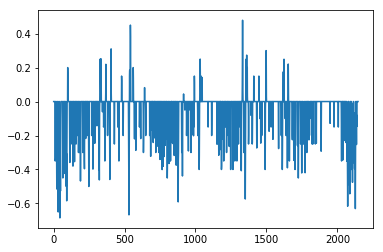

In [1]:
onServer = True

import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

LOG_DIR = '/Users/tempflip/Desktop/rec2/'
SERVER_LOG_DIR = '/home/carnd/rec2/'
LOG_FILE  = 'driving_log.csv'
log = []

if onServer : dr = SERVER_LOG_DIR
else : dr = LOG_DIR

with open(dr + '/' + LOG_FILE, 'r') as f:
    reader = csv.reader(f)
    log = pd.DataFrame([row for row in reader], columns=['CENTER', 
                                                         'LEFT',
                                                         'RIGHT',
                                                         'STEERING',
                                                         'THROTTLE',
                                                         'BRAKE',
                                                         'SPEED'
                                                        ])

#print(log[['CENTER', 'STEERING']])
plt.plot(log['STEERING'])


(2147,)
(2147, 160, 320, 3)
255.0 0.0


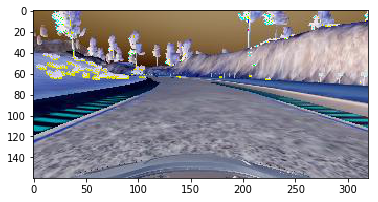

In [7]:
from scipy import misc
im_list = []
steering_targets = []
STEERING_ADJUST = 0.1

for i in range(len(log['CENTER'].values)):
    c, l, r = log[['CENTER', 'LEFT', 'RIGHT']].values[i]
    if onServer : 
        c = c.replace(LOG_DIR, SERVER_LOG_DIR)
        l = l.replace(LOG_DIR, SERVER_LOG_DIR)
        r = r.replace(LOG_DIR, SERVER_LOG_DIR)
     
    # center camera
    im = misc.imread(c)
    im_list.append(im)
    steering_targets.append(log['STEERING'].values[i])

    # left camera
    #im = misc.imread(l) 
    #im_list.append(im)
    #steering_targets.append(float(log['STEERING'].values[i]) + STEERING_ADJUST)    
    # right camera
    # left camera
    #im = misc.imread(r) 
    #im_list.append(im)
    #steering_targets.append(float(log['STEERING'].values[i]) - STEERING_ADJUST)  
    
im_list = np.array(im_list, dtype=np.float32)
steering_targets = np.array(steering_targets, dtype=np.float32)

assert(steering_targets.shape[0] == im_list.shape[0])

print (steering_targets.shape)
print (im_list.shape)
print (np.max(im_list), np.min(im_list))
plt.imshow(im_list[100])

.
.
.
.
.
.
.
Elements:  (4294, 160, 320, 3)


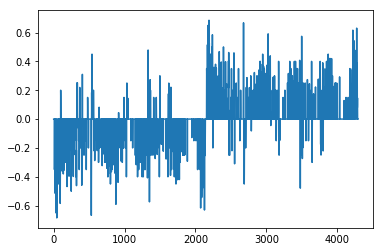

In [8]:
## data augmentation

## flipping
def flip(im, angle):
    return (np.fliplr(im), - angle)

# flipping
i = 0
f_im_list, f_steering_targets = [], []
for im, angle in zip(im_list, steering_targets):
    f_im, f_angle = flip(im, angle)
    f_im_list.append(f_im)
    f_steering_targets.append(f_angle)
    i+= 1
    if i%300 == 0 : print (".")
    
assert(len(f_im_list) == len(f_steering_targets))
    
f_im_list = np.array(f_im_list, dtype=np.float32)
f_steering_targets = np.array(f_steering_targets, dtype=np.float32)


im_list = np.concatenate((im_list, f_im_list))
steering_targets = np.concatenate((steering_targets, f_steering_targets))

assert(steering_targets.shape[0] == im_list.shape[0])

print('Elements: ', im_list.shape)

plt.plot(steering_targets)


In [48]:
"""
import cv2
import colorsys

def colorconv(d):
    return np.apply_along_axis(rr, 3, d)

def rr(x):
    v = colorsys.rgb_to_hsv(x[0], x[1], x[2])
    return np.array(v, dtype=np.float32)

plt.subplot(2,3,1)
plt.imshow(im_list[100,:,:,0])
plt.subplot(2,3,2)
plt.imshow(im_list[100,:,:,1])
plt.subplot(2,3,3)
plt.imshow(im_list[100,:,:,2])

x = colorconv(im_list[0:10])[5]

plt.subplot(2,3,4)
plt.imshow(x[:,:,0])
plt.subplot(2,3,5)
plt.imshow(x[:,:,1])
plt.subplot(2,3,6)
plt.imshow(x[:,:,2])
"""



'\nimport cv2\nimport colorsys\n\ndef colorconv(d):\n    return np.apply_along_axis(rr, 3, d)\n\ndef rr(x):\n    v = colorsys.rgb_to_hsv(x[0], x[1], x[2])\n    return np.array(v, dtype=np.float32)\n\nplt.subplot(2,3,1)\nplt.imshow(im_list[100,:,:,0])\nplt.subplot(2,3,2)\nplt.imshow(im_list[100,:,:,1])\nplt.subplot(2,3,3)\nplt.imshow(im_list[100,:,:,2])\n\nx = colorconv(im_list[0:10])[5]\n\nplt.subplot(2,3,4)\nplt.imshow(x[:,:,0])\nplt.subplot(2,3,5)\nplt.imshow(x[:,:,1])\nplt.subplot(2,3,6)\nplt.imshow(x[:,:,2])\n'

[<tf.Tensor 'add_32:0' shape=(?, 1) dtype=float32>]
(4294, 160, 320, 3) (4294,)


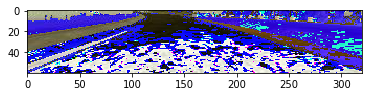

In [9]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

def crop(d):
    return d[:,60:120,:,:]

def normalize(d):
    return d / 255 - 0.5



model = Sequential()

model.add(Lambda(normalize, input_shape=(160, 320, 3)))
model.add(Lambda(crop))


model.add(Convolution2D(9,3,3, border_mode="same"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.1))

model.add(Convolution2D(18,3,3, border_mode="same"))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(10))
model.add(Dense(1))

#print(model.inputs)
print(model.outputs)

print(im_list.shape, steering_targets.shape)

l = 200
plt.imshow(crop(normalize((im_list[l:l+1])))[0])



In [10]:
from sklearn.utils import shuffle
N = 4294
#x_shuffled, y_shuffled = shuffle(im_list, steering_targets)
x_shuffled, y_shuffled = im_list, steering_targets
x_train = x_shuffled[:N]
y_train = y_shuffled[:N]


In [11]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
history = model.fit(x_train, y_train, nb_epoch=10, validation_split=0.2, batch_size=100, shuffle=True)


Train on 3435 samples, validate on 859 samples
Epoch 1/10
3435/3435 [==============================] - 6s - loss: 0.8121 - acc: 0.4195 - val_loss: 0.0409 - val_acc: 0.7055

KeyboardInterrupt: 

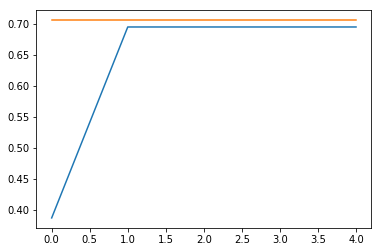

In [33]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

In [34]:
model.save('/home/carnd/my_model.h5')
#model.save('/my_model.h5')
print("Saved.")

Saved.
